In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch

sys.path.append('../src')
from ncp import NCP
from utils import show_dataset

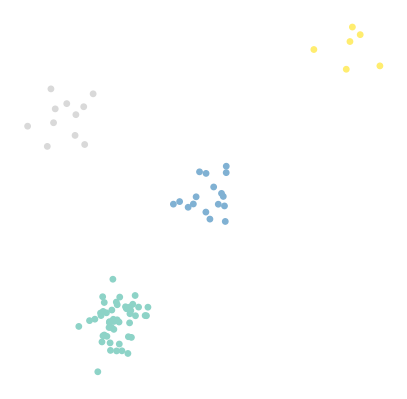

In [54]:
def relable(cs):
    cs, d, k = cs.copy(), {}, 0
    
    for i in range(len(cs)):
        j = cs[i]

        if j not in d:
            d[j] = k
            k += 1
        
        cs[i] = d[j]

    return cs

def generate(alpha=.7, N=None, N_min=5, N_max=100, no_ones=False):
    keep = True

    while keep:
        if N is None or N == 0:
            N = np.random.randint(N_min, N_max)
        clusters = np.zeros(N + 2)
        clusters[0], clusters[1], clusters[2] = 0, 1, alpha
        index_new = 2

        for n in range(N - 1):
            p = clusters/clusters.sum()
            z = np.argmax(np.random.multinomial(1, p))

            if z < index_new:
                clusters[z] += 1
            else:
                clusters[index_new] = 1
                index_new += 1
                clusters[index_new] = alpha

        clusters[index_new] = 0
        clusters = clusters.astype(np.int32)

        if no_ones:
            clusters = clusters[clusters != 1]

        N = int(np.sum(clusters))
        keep = N == 0

    K = np.sum(clusters > 0)

    return clusters, N, K

class Data:
    def __init__(self, x_dim=2, lamb=10, sigma=1, alpha=.7, N_min=5, N_max=100):
        self.n_features = x_dim
        self.lamb = lamb
        self.sigma = sigma
        self.alpha = alpha
        self.N_min = N_min
        self.N_max = N_max

    def make(self, N=None, batch_size=16, return_tensor=True):
        clusters, N, n_clusters = generate(self.alpha, N, self.N_min, self.N_max)
        cumsum = np.cumsum(clusters)
        data = np.empty((batch_size, N, self.n_features))
        cs = np.empty(N, dtype=np.int32)

        for i in range(n_clusters):
            mu = np.random.normal(0, self.lamb, size=(self.n_features*batch_size, 1))
            samples = np.random.normal(mu, self.sigma, size=(self.n_features*batch_size, clusters[i + 1]))
            samples = np.swapaxes(samples.reshape((batch_size, self.n_features, clusters[i + 1])), 1, 2)
            data[:, cumsum[i]:cumsum[i + 1], :] = samples
            cs[cumsum[i]:cumsum[i + 1]] = i + 1

        arr = np.arange(N)
        np.random.shuffle(arr)
        cs = cs[arr]
        data = data[:, arr, :]
        cs = relable(cs)
        medians = np.expand_dims(np.median(data, axis=1), 1)
        data = data - medians

        if return_tensor:
            return torch.tensor(data, dtype=torch.float32), torch.tensor(cs)

        # return data, cs, clusters, n_clusters
        return data, cs
    
generator = Data(x_dim=3)
data, labels = generator.make()
show_dataset(data[0], labels)

NCP: 100%|██████████| 400/400 [05:16<00:00,  1.27it/s]


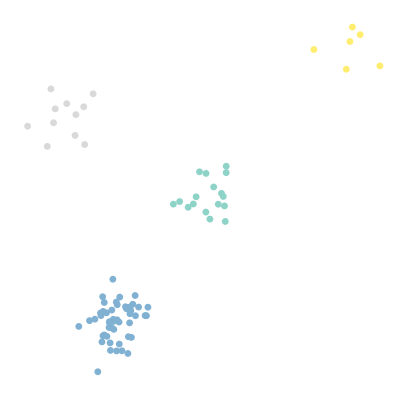

In [61]:
WC_CHANNELS = 64, 64
BC_CHANNELS = 256, 256
LP_CHANNELS = 64, 64

model = NCP(WC_CHANNELS, BC_CHANNELS, LP_CHANNELS).fit(Data(x_dim=3), n_steps=400)
show_dataset(data[0], model(data))

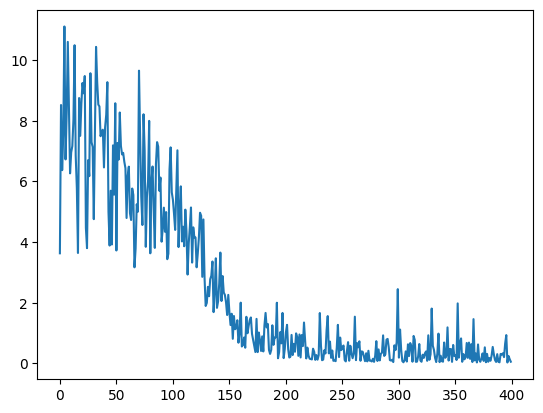

In [62]:
arr = np.arange(len(model.nll_log))
plt.plot(arr, model.nll_log)
plt.show()

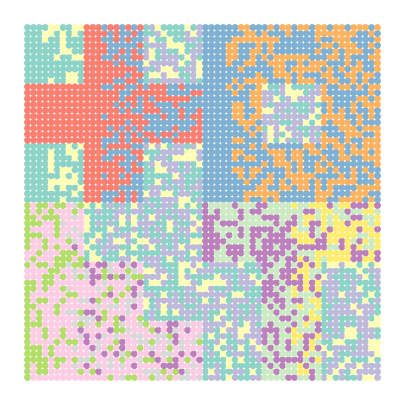

In [63]:
show_dataset(z_locs, model(z_test), sectioned=True)

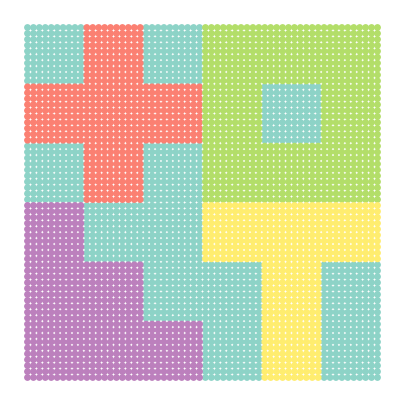

In [49]:
topics = model.encoder(z_test.repeat(16, 1, 1))
show_dataset(z_locs, topics, sectioned=True)

In [72]:
data.repeat(10, 1, 1).shape

torch.Size([10, 18000, 6])

In [81]:
import torch.nn as nn
from tqdm import tqdm
from ncp import Encoder
from utils import shuffle

class NCP2(NCP):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def fit(self, data, labels, n_steps=200, n_permutations=6, learning_rate=1e-4, weight_decay=0., batch_size=16, n_samples=64, verbosity=1, description='NCP'):
        self.batch_size = max(data.shape[0], batch_size)
        self.build(data.shape[-1], learning_rate, weight_decay)

        for _ in tqdm(range(n_steps), description) if verbosity == 1 else range(n_steps):
            mask, nll = torch.randperm(data.shape[0])[:batch_size], 0

            for _ in range(n_permutations):
                X, y = shuffle(data[mask], labels, sort=True, cut=n_samples)
                nll += self.evaluate(X, y, grad=True)

            self.step(nll)

        return self
    
    def forward(self, data):
        if data.shape[0] == 1 or len(data.shape) == 2:
            data = data.repeat(self.batch_size, 1, 1)

        topics = self.encoder(data)
        
        return topics
    
class Encoder3(Encoder):
    pass

class Decoder3(nn.Module):
    pass

class NCP3(NCP):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def evaluate(self, data, grad=False):
        topics = self.encoder(data)
        encoding = None # TODO
        reconstruction = self.decoder(topics)
        loss = 0 # TODO

        if grad:
            loss.backward()
        
        return loss.item()

    def fit(self, data, n_steps=1000, n_permutations=6, learning_rate=1e-4, weight_decay=1e-2, batch_size=16, n_samples=32, verbosity=1, description='NCP'):
        self.build(data.shape[-1], learning_rate, weight_decay)

        for _ in tqdm(range(n_steps), description) if verbosity == 1 else range(n_steps):
            mask, loss = torch.randperm(data.shape[0])[:batch_size], 0

            for _ in range(n_permutations):
                X, y = shuffle(data[mask], cut=n_samples)
                loss += self.evaluate(X, y, grad=True)

            self.step(loss)

        return self

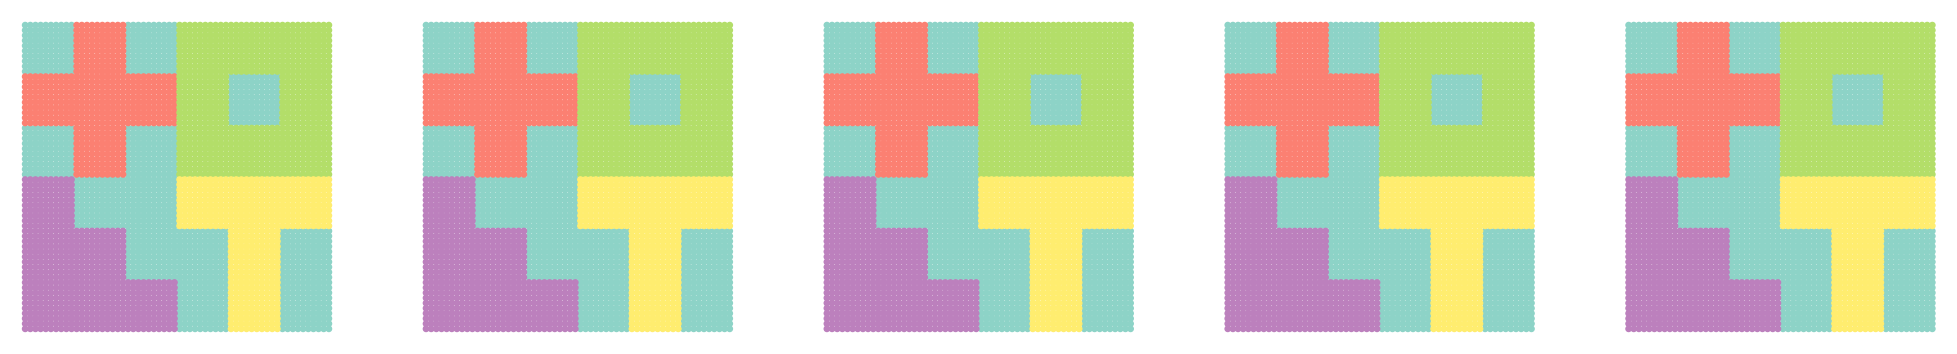

In [2]:
from sim import make_dataset

N_DATASETS = 4
TEMPLATE = ('polygons',) + ('polygons',)*N_DATASETS
BLOCK_SIZE = (10, 10)

data, labels = make_dataset(TEMPLATE, n_features=3, block_size=BLOCK_SIZE, return_tensor=True)

x = data[data[data[:, 0] == 0].shape[0]:]
x = x.view(N_DATASETS, x.shape[0]//N_DATASETS, x.shape[-1])[..., 3:]
y = labels[data[data[:, 0] == 0].shape[0]:data[data[:, 0] == 0].shape[0] + x.shape[1]]
z = data[:data[data[:, 0] == 0].shape[0]]
z_locs, z_test = z[:, :3], z[None][..., 3:]

show_dataset(data, labels, sectioned=True)

In [21]:
data, labels = make_dataset(return_tensor=True)

In [22]:
torch.cdist(data[:, 1:3], data[:, 1:3]).argsort(-1)

tensor([[   0, 2529,    1,  ..., 2499, 1181, 1180],
        [   1,    2,   21,  ..., 1160, 1181, 1180],
        [   2,   22,    1,  ..., 1160, 1181, 1180],
        ...,
        [3597, 3598, 3596,  ...,   39,   18,   19],
        [3598, 3597, 3599,  ...,   39,   18,   19],
        [3599, 3589, 3598,  ...,   18, 2500,   19]])

In [40]:
from scipy.cluster.vq import kmeans, vq
from sklearn.neighbors import NearestNeighbors

def count(x, vocab_size):
    x_counts = torch.zeros((x.shape[0], vocab_size))
    for i in range(x.shape[0]):
        idx, counts = torch.unique(x[i], return_counts=True)
        for j in range(idx.shape[0]):
            x_counts[i, idx[j].to(torch.int32)] = counts[j].to(torch.int32)
    return x_counts

def build(x, n_words, vocab_size, vocab_steps=10, return_counts=False):
    codebook, _ = kmeans(x[:, 4:], vocab_size, vocab_steps)
    neighbors = NearestNeighbors(n_neighbors=n_words).fit(x[:, :4])
    _, neighbor_idx = neighbors.kneighbors(x[:, :4])
    data = np.zeros((x.shape[0], n_words), dtype=np.int32)
    for i in range(x.shape[0]):
        data[i], _ = vq(x[neighbor_idx, 4:][i], codebook)
    data_tensor = torch.tensor(data, dtype=torch.float32)
    if return_counts:
        return data_tensor, count(data_tensor, vocab_size)
    return data_tensor

In [42]:
corpus, counts = build(data, 10, 5, return_counts=True)

In [71]:
n_words, vocab_size = 10, 5

codebook, _ = kmeans(data[:, 3:], vocab_size)
neighbors = NearestNeighbors(n_neighbors=n_words).fit(data[:, 1:3])
_, idx = neighbors.kneighbors(data[:, 1:3])
corpus = np.zeros((data.shape[0], n_words), dtype=np.int32)

vq(data[idx, 3:][0], codebook)[0]

array([3, 0, 3, 3, 0, 3, 0, 3, 3, 3], dtype=int32)

In [62]:
n_words = 10

knn = torch.cdist(data[:, 1:3], data[:, 1:3]).topk(n_words, largest=False).indices
knn

tensor([[   0, 2529,    1,  ..., 2528,   40,   41],
        [   1,   21,    2,  ...,   41,    3,   23],
        [   2,   22,    3,  ...,   42,    0,   24],
        ...,
        [3597, 3596, 3587,  ..., 3595, 3577, 3578],
        [3598, 3599, 3597,  ..., 3578, 2470, 3579],
        [3599, 2470, 3589,  ..., 3597, 2471, 3587]])

In [33]:
torch.cdist(data[:, 1:3], data[:, 1:3]).argsort(-1)

tensor([[   0, 2529,    1,  ..., 2499, 1181, 1180],
        [   1,    2,   21,  ..., 1160, 1181, 1180],
        [   2,   22,    1,  ..., 1160, 1181, 1180],
        ...,
        [3597, 3598, 3596,  ...,   39,   18,   19],
        [3598, 3597, 3599,  ...,   39,   18,   19],
        [3599, 3589, 3598,  ...,   18, 2500,   19]])

In [39]:
torch.cdist(data[:, 1:3], data[:, 1:3]).topk(3, largest=False).indices

tensor([[   0,   20,    1],
        [   1,    0,    2],
        [   2,    3,    1],
        ...,
        [3597, 3596, 3587],
        [3598, 3588, 3597],
        [3599, 3589, 3598]])

In [11]:
(z[:, 1:3][None, :] - z[:, 1:3][:, None]).square().sum(-1).sqrt().argsort(-1)

tensor([[   0, 2529,    1,  ..., 2499, 1181, 1180],
        [   1,    2,   21,  ..., 1160, 1181, 1180],
        [   2,   22,    1,  ..., 1160, 1181, 1180],
        ...,
        [3597, 3598, 3596,  ...,   39,   18,   19],
        [3598, 3597, 3599,  ...,   39,   18,   19],
        [3599, 3589, 3598,  ...,   18, 2500,   19]])

NCP: 100%|██████████| 200/200 [01:47<00:00,  1.85it/s]


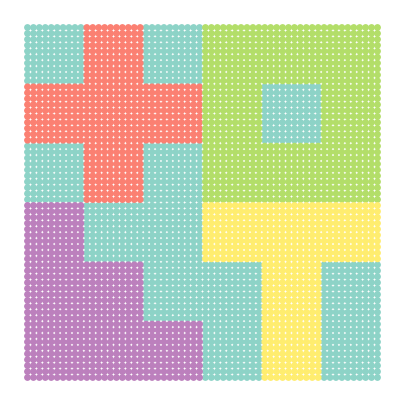

In [83]:
WC_CHANNELS = (128, 128)
BC_CHANNELS = (512, 512)
LP_CHANNELS = (128, 128)

model = NCP2(WC_CHANNELS, BC_CHANNELS, LP_CHANNELS).fit(x, y)
show_dataset(z_locs, model(z_test), sectioned=True)

In [102]:
(data[:, :2] - data[:, -2:]).norm(dim=1).topk(3, largest=False)

torch.return_types.topk(
values=tensor([4.1971, 4.2095, 4.4543]),
indices=tensor([14586, 14615, 14623]))

In [119]:
(data[:, :2].unsqueeze(0) - data[:, :2].unsqueeze(1)).square().sum(-1).sqrt().argsort(-1)

tensor([[ 2529,     1,     2,  ..., 17997, 17998, 16897],
        [ 2529,     1,     2,  ..., 17997, 17998, 16897],
        [ 2529,     1,     2,  ..., 17997, 17998, 16897],
        ...,
        [15580, 16899, 15581,  ...,     2,     1,     0],
        [15580, 16899, 15581,  ...,     2,     1,     0],
        [15580, 16899, 15581,  ...,     2,     1,     0]])

In [117]:
(data[:, :2][None, :] - data[:, :2][:, None]).shape

torch.Size([18000, 18000, 2])

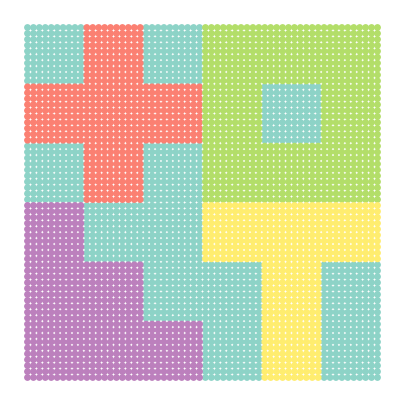

In [86]:
show_dataset(z_locs, model(z_test), sectioned=True)

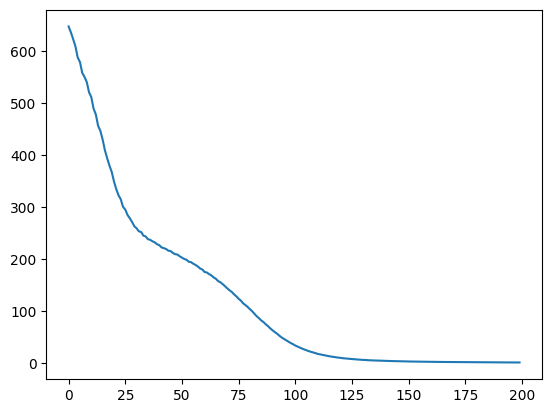

In [93]:
arr = np.arange(len(model.nll_log))
plt.plot(arr, model.nll_log)
plt.show()